In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

BASE_DIR = os.getcwd()

DATA_PATH = os.path.join(BASE_DIR, "..", "data", "fashion_products.csv")

data = pd.read_csv(DATA_PATH)

data.head()

print("Dataset loaded:", data.shape)

Dataset loaded: (1000, 9)


,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M


Content-based Recommender System

In [3]:
# Créer la table produit (1 ligne = 1 produit)
products = data.groupby("Product ID").agg({
    "Product Name": "first",
    "Brand": "first",
    "Category": "first",
    "Color": "first",
    "Size": "first",
    "Price": "mean",
    "Rating": "mean"
}).reset_index()

print("Products table:", products.shape)
products.head()


Products table: (1000, 8)


,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
0,1,Dress,Adidas,Men's Fashion,Black,XL,40.0,1.043159
1,2,Shoes,H&M,Women's Fashion,Black,L,82.0,4.026416
2,3,Dress,Adidas,Women's Fashion,Yellow,XL,44.0,3.337938
3,4,Shoes,Zara,Men's Fashion,White,S,23.0,1.049523
4,5,T-shirt,Adidas,Men's Fashion,Black,M,79.0,4.302773


In [4]:
# Colonnes catégorielles
cat_cols = ["Brand", "Category", "Color", "Size"]

# Colonnes numériques
num_cols = ["Price", "Rating"]

X_cat = products[cat_cols].astype(str)
X_num = products[num_cols].astype(float)

One-Hot Encoding des features catégorielles

In [5]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_cat_encoded = encoder.fit_transform(X_cat)

encoded_feature_names = encoder.get_feature_names_out(X_cat.columns)

print("Encoded categorical shape:", X_cat_encoded.shape)
print("Feature names:", encoded_feature_names)


Encoded categorical shape: (1000, 18)
Feature names: ['Brand_Adidas' 'Brand_Gucci' 'Brand_H&M' 'Brand_Nike' 'Brand_Zara'
 "Category_Kids' Fashion" "Category_Men's Fashion"
 "Category_Women's Fashion" 'Color_Black' 'Color_Blue' 'Color_Green'
 'Color_Red' 'Color_White' 'Color_Yellow' 'Size_L' 'Size_M' 'Size_S'
 'Size_XL']


In [6]:
# Normalisation des colonnes numériques
scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(X_num)

print("Scaled numerical shape:", X_num_scaled.shape)

Scaled numerical shape: (1000, 2)


In [7]:
# Matrice finale : concaténer One-Hot + Numérique
feature_matrix = np.hstack([X_cat_encoded, X_num_scaled])

print("Final feature matrix:", feature_matrix.shape)

Final feature matrix: (1000, 20)


In [8]:
def recommend_content_based(product_id, top_k=5):
    # Trouver l'index du produit dans la table "products"
    idx_list = products.index[products["Product ID"] == product_id].tolist()
    if not idx_list:
        raise ValueError(f"Product ID {product_id} not found.")
    idx = idx_list[0]

    # Calculer similarités
    query_vec = feature_matrix[idx].reshape(1, -1)
    sims = cosine_similarity(query_vec, feature_matrix)[0]

    # Sélectionner top_k similaires (exclure lui-même)
    similar_idx = np.argsort(-sims)[1 : top_k + 1]

    # Renvoyer les résultats
    results = products.iloc[similar_idx].copy()
    results["similarity"] = sims[similar_idx]

    return results.sort_values("similarity", ascending=False)


In [9]:
test_product = 15   

print("Details du produit sélectionné :")
products[products["Product ID"] == test_product]

Details du produit sélectionné :


,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
14,15,Shoes,Zara,Men's Fashion,Yellow,M,54.0,3.670412


In [10]:
print("Content-Based Recommendations for Product ID =", test_product)
recommend_content_based(test_product, top_k=5)

Content-Based Recommendations for Product ID = 15


,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating,similarity
85,86,Sweater,Zara,Men's Fashion,Yellow,M,50.0,3.276222,0.998883
560,561,Shoes,Zara,Men's Fashion,Yellow,M,96.0,3.968456,0.980899
181,182,Jeans,Zara,Men's Fashion,Yellow,L,68.0,4.358913,0.791448
512,513,Jeans,Zara,Men's Fashion,Green,M,65.0,4.061791,0.790524
262,263,Jeans,Zara,Men's Fashion,Yellow,XL,71.0,4.053595,0.790432


Evaluation

In [11]:
def get_true_relevant_products(product_id):
    """
    Retourne les produits réellement pertinents selon :
    - même catégorie
    - même brand
    """
    
    target_row = products[products["Product ID"] == product_id]
    
    if target_row.empty:
        return set()
    
    target_cat = target_row["Category"].values[0]
    target_brand = target_row["Brand"].values[0]
    
    # Produits avec même category ET même brand
    relevant = products[
        (products["Category"] == target_cat) &
        (products["Brand"] == target_brand)
    ]
    
    # Exclure le produit lui-même
    relevant = relevant[relevant["Product ID"] != product_id]
    
    return set(int(x) for x in relevant["Product ID"].values)

In [12]:
def evaluate_product(product_id, k=5):
    # 1) Récupérer les vrais produits pertinents (same category + same brand)
    relevant = get_true_relevant_products(product_id)
    # 2) Obtenir les recommandations
    recs = recommend_content_based(product_id, top_k=k)
    recommended_ids = recs["Product ID"].tolist()
    
    # 3) Calcul des métriques
    p_at_k = precision_at_k(recommended_ids, relevant, k)
    r_at_k = recall_at_k(recommended_ids, relevant, k)
    
    return p_at_k, r_at_k, relevant, recommended_ids


Constraint-Based

In [15]:
def recommend_constraint_based(
    base_product_id=None,
    category=None,
    brand=None,
    max_price=None,
    min_price=None,
    color=None,
    size=None,
    min_rating=None,
    top_k=20
):
    
    
    df = products.copy()
    
    # 1) Si on part d'un produit de base, on peut réutiliser sa catégorie / brand
    if base_product_id is not None:
        base_row = products[products["Product ID"] == base_product_id]
        if base_row.empty:
            raise ValueError(f"Product ID {base_product_id} not found.")
        
        if category is None:
            category = base_row["Category"].values[0]
        if brand is None:
            brand = base_row["Brand"].values[0]
    
    # 2) Application des contraintes
    if category is not None:
        df = df[df["Category"] == category]
    if brand is not None:
        df = df[df["Brand"] == brand]
    if color is not None:
        df = df[df["Color"] == color]
    if size is not None:
        df = df[df["Size"] == size]
    if max_price is not None:
        df = df[df["Price"] <= max_price]
    if min_price is not None:
        df = df[df["Price"] >= min_price]
    if min_rating is not None:
        df = df[df["Rating"] >= min_rating]
    
    # 3) Ne pas recommander le produit de départ lui-même
    if base_product_id is not None:
        df = df[df["Product ID"] != base_product_id]
    
    # 4) Trier par meilleur rating puis par prix croissant
    df = df.sort_values(by=["Rating", "Price"], ascending=[False, True])
    
    # 5) Limiter à top_k résultats
    return df.head(top_k)


In [ ]:
def show_product(product_id):
    prod = products[products["Product ID"] == product_id]
    if prod.empty:
        print(f"Produit {product_id} introuvable.")
    else:
        display(prod)
        
# Exemple :
show_product(10) 


,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
9,10,T-shirt,Zara,Kids' Fashion,White,XL,55.0,4.093234


In [17]:
test_product = 10 

print("Produit de référence :")
show_product(test_product)

print("\nRecommandations (même category + même brand, prix <= même prix) :")
base_price = products.loc[products["Product ID"] == test_product, "Price"].values[0]

recs = recommend_constraint_based(
    base_product_id=test_product,
    max_price=base_price,  # ne pas dépasser le prix du produit de base
    min_rating=4.0,        # seulement les produits bien notés
    top_k=10
)

recs


Produit de référence :


,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
9,10,T-shirt,Zara,Kids' Fashion,White,XL,55.0,4.093234



Recommandations (même category + même brand, prix <= même prix) :


,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
501,502,Dress,Zara,Kids' Fashion,Blue,M,33.0,4.987964
36,37,Sweater,Zara,Kids' Fashion,Blue,S,48.0,4.947665
426,427,T-shirt,Zara,Kids' Fashion,Yellow,XL,15.0,4.717963
642,643,T-shirt,Zara,Kids' Fashion,Black,L,42.0,4.628099
166,167,Shoes,Zara,Kids' Fashion,Blue,S,43.0,4.478061
561,562,T-shirt,Zara,Kids' Fashion,Green,L,29.0,4.440106
653,654,Shoes,Zara,Kids' Fashion,Blue,S,42.0,4.276503
630,631,T-shirt,Zara,Kids' Fashion,White,S,32.0,4.197234
189,190,Sweater,Zara,Kids' Fashion,Yellow,XL,32.0,4.033069
62,63,Jeans,Zara,Kids' Fashion,White,L,55.0,4.026271


In [18]:
recs_constraints = recommend_constraint_based(
    category="Men's Fashion",
    brand="Nike",
    max_price=60,
    min_rating=4.0,
    top_k=15
)

recs_constraints


,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
956,957,Jeans,Nike,Men's Fashion,White,L,57.0,4.928869
310,311,Jeans,Nike,Men's Fashion,Black,L,55.0,4.803390
141,142,Shoes,Nike,Men's Fashion,White,XL,38.0,4.403932
187,188,Shoes,Nike,Men's Fashion,Green,XL,44.0,4.359930
86,87,Shoes,Nike,Men's Fashion,Red,S,41.0,4.126942
270,271,Jeans,Nike,Men's Fashion,Blue,L,45.0,4.075216


Knowledge-based

In [19]:
price_q = products["Price"].quantile([0.33, 0.66])
cheap_max = price_q.loc[0.33]
mid_max   = price_q.loc[0.66]

print("Seuils de prix :")
print(f"  Cheap   : Price <= {cheap_max:.2f}")
print(f"  Mid     : {cheap_max:.2f} < Price <= {mid_max:.2f}")
print(f"  Premium : Price  > {mid_max:.2f}")

Seuils de prix :
  Cheap   : Price <= 40.00
  Mid     : 40.00 < Price <= 71.00
  Premium : Price  > 71.00


In [20]:
# Liste des marques uniques dans le dataset
brands = products["Brand"].dropna().unique()

print("Nombre de marques :", len(brands))
print("\nListe des marques :")
for b in sorted(brands):
    print("-", b)

Nombre de marques : 5

Liste des marques :
- Adidas
- Gucci
- H&M
- Nike
- Zara


In [21]:
def knowledge_based_recommend(
    usage=None,          # "sport", "casual", "work", "chic"
    budget_level=None,   # "cheap", "mid", "premium"
    preferred_color=None,
    preferred_size=None,
    preferred_brand=None,
    min_rating=3.5,
    top_k=20
):
    df = products.copy()
    
    # --------------------------
    # 1) Règles de budget (cheap/mid/premium)
    # --------------------------
    if budget_level == "cheap":
        df = df[df["Price"] <= cheap_max]
    elif budget_level == "mid":
        df = df[(df["Price"] > cheap_max) & (df["Price"] <= mid_max)]
    elif budget_level == "premium":
        df = df[df["Price"] > mid_max]
    
    # --------------------------
    # 2) Règles d'usage (profil utilisateur)
    # --------------------------
    if usage is not None:
        usage = usage.lower()

        if usage == "sport":
            # Marques sportives
            sport_brands = ["Adidas", "Nike"]
            df = df[df["Brand"].isin(sport_brands)]
        
        elif usage == "casual":
            # Marques casual / fast fashion
            casual_brands = ["H&M", "Zara"]
            df = df[df["Brand"].isin(casual_brands)]
        
        elif usage == "work":
            # Tenues de travail 
            work_colors = ["Black", "Grey", "Navy", "White"]
            df = df[df["Color"].isin(work_colors)]
            # Marques abordables pour le travail
            df = df[df["Brand"].isin(["H&M", "Zara", "Nike", "Adidas"])]
        
        elif usage == "chic":
            # Style chic = marque luxe + couleur élégante
            chic_colors = ["Black", "Red", "Gold", "Silver"]
            df = df[df["Color"].isin(chic_colors)]
            df = df[df["Brand"] == "Gucci"]
            df = df[df["Rating"] >= 4.0]
    
    # --------------------------
    # 3) Préférences explicites
    # --------------------------
    if preferred_color is not None:
        df = df[df["Color"] == preferred_color]
    
    if preferred_size is not None:
        df = df[df["Size"] == preferred_size]
    
    if preferred_brand is not None:
        df = df[df["Brand"] == preferred_brand]
    
    # --------------------------
    # 4) Règle qualité (rating minimum)
    # --------------------------
    df = df[df["Rating"] >= min_rating]
    
    # --------------------------
    # 5) Tri final (qualité puis prix)
    # --------------------------
    df = df.sort_values(by=["Rating", "Price"], ascending=[False, True])
    
    return df.head(top_k)


In [22]:
knowledge_based_recommend(
    usage="sport",
    budget_level="mid",
    min_rating=4.0,
    top_k=10
)

,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
926,927,T-shirt,Adidas,Men's Fashion,White,XL,71.0,4.946758
956,957,Jeans,Nike,Men's Fashion,White,L,57.0,4.928869
92,93,Shoes,Nike,Men's Fashion,White,S,70.0,4.928128
299,300,Shoes,Adidas,Kids' Fashion,White,S,57.0,4.923509
730,731,Sweater,Adidas,Men's Fashion,White,XL,62.0,4.898212
125,126,T-shirt,Nike,Kids' Fashion,Green,M,55.0,4.851704
151,152,Jeans,Nike,Men's Fashion,Green,S,71.0,4.815682
310,311,Jeans,Nike,Men's Fashion,Black,L,55.0,4.803390
160,161,Sweater,Adidas,Women's Fashion,Blue,M,67.0,4.735472
551,552,Sweater,Adidas,Kids' Fashion,Blue,M,50.0,4.480169


In [23]:
knowledge_based_recommend(
    usage="chic",
    budget_level="premium",
    preferred_color="Black",
    min_rating=4.2,
    top_k=10
)

,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
991,992,T-shirt,Gucci,Women's Fashion,Black,M,91.0,4.922173
573,574,Jeans,Gucci,Women's Fashion,Black,L,92.0,4.491894
895,896,Jeans,Gucci,Men's Fashion,Black,S,80.0,4.369727


In [24]:
knowledge_based_recommend(
    usage="work",
    min_rating=4.0,
    preferred_color="Black",
    top_k=10
)

,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
198,199,T-shirt,Zara,Women's Fashion,Black,M,15.0,4.980656
732,733,Sweater,Adidas,Women's Fashion,Black,M,75.0,4.891156
180,181,Shoes,H&M,Kids' Fashion,Black,L,80.0,4.829055
310,311,Jeans,Nike,Men's Fashion,Black,L,55.0,4.803390
268,269,Shoes,H&M,Kids' Fashion,Black,S,100.0,4.743391
988,989,T-shirt,Adidas,Men's Fashion,Black,S,78.0,4.715257
644,645,T-shirt,Zara,Kids' Fashion,Black,S,98.0,4.696077
871,872,Jeans,H&M,Women's Fashion,Black,M,96.0,4.646393
425,426,Jeans,Zara,Men's Fashion,Black,L,48.0,4.644768
642,643,T-shirt,Zara,Kids' Fashion,Black,L,42.0,4.628099


# Modèle hybride

scores content-based pour tous les produits

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

def get_content_scores(product_id):
    """
    Retourne un Series: index = Product ID, valeur = similarité cosinus
    entre le produit cible et tous les autres produits.
    """
    # trouver l'index du produit dans "products"
    idx_list = products.index[products["Product ID"] == product_id].tolist()
    if not idx_list:
        raise ValueError(f"Product ID {product_id} not found in products.")
    idx = idx_list[0]
    
    # vecteur du produit cible
    query_vec = feature_matrix[idx].reshape(1, -1)
    
    # similarité cosinus avec tous les produits
    sims = cosine_similarity(query_vec, feature_matrix)[0]
    
    # Series avec index = Product ID
    return pd.Series(sims, index=products["Product ID"])


scores Constraint-Based (0 ou 1)

In [26]:
def get_constraint_scores(
    base_product_id=None,
    category=None,
    brand=None,
    max_price=None,
    min_price=None,
    color=None,
    size=None,
    min_rating=None
):
    """
    Retourne un Series indexé par Product ID avec un score binaire:
      1.0 si le produit respecte les contraintes
      0.0 sinon
    """
    # on récupère tous les produits qui respectent les contraintes
    candidates = recommend_constraint_based(
        base_product_id=base_product_id,
        category=category,
        brand=brand,
        max_price=max_price,
        min_price=min_price,
        color=color,
        size=size,
        min_rating=min_rating,
        top_k=len(products)  # on prend tout
    )
    
    valid_ids = set(candidates["Product ID"])
    
    scores = products["Product ID"].apply(lambda pid: 1.0 if pid in valid_ids else 0.0)
    scores.index = products["Product ID"]
    return scores


scores Knowledge-Based (0 ou 1)

In [27]:
def get_knowledge_scores(
    usage=None,
    budget_level=None,
    preferred_color=None,
    preferred_size=None,
    preferred_brand=None,
    min_rating_kb=3.5
):
    """
    Retourne un Series indexé par Product ID avec un score binaire:
      1.0 si le produit est sélectionné par le knowledge-based
      0.0 sinon
    """
    candidates = knowledge_based_recommend(
        usage=usage,
        budget_level=budget_level,
        preferred_color=preferred_color,
        preferred_size=preferred_size,
        preferred_brand=preferred_brand,
        min_rating=min_rating_kb,
        top_k=len(products)  # on prend tout
    )
    
    valid_ids = set(candidates["Product ID"])
    
    scores = products["Product ID"].apply(lambda pid: 1.0 if pid in valid_ids else 0.0)
    scores.index = products["Product ID"]
    return scores


# Fonction du modèle hybride

On combine les trois scores : 
    content_norm ∈ [0,1] ,
    constraint_score ∈ {0,1}, 
    knowledge_score ∈ {0,1}

Avec des poids :
    w_content (par défaut 0.6)
    w_constraint (0.2)
    w_knowledge (0.2)

In [28]:
def hybrid_recommend(
    base_product_id,
    # paramètres constraint-based
    category=None,
    brand=None,
    max_price=None,
    min_price=None,
    color=None,
    size=None,
    min_rating_constraint=None,
    # paramètres knowledge-based
    usage=None,           # "sport", "casual", "work", "chic"
    budget_level=None,    # "cheap", "mid", "premium"
    preferred_color_kb=None,
    preferred_size_kb=None,
    preferred_brand_kb=None,
    min_rating_kb=3.5,
    # poids du modèle
    w_content=0.6,
    w_constraint=0.2,
    w_knowledge=0.2,
    top_k=10
):
    """
    Modèle hybride combinant:
      - Content-Based (similarité cosinus)
      - Constraint-Based (contraintes explicites)
      - Knowledge-Based (règles métier)
    """
    
    # 1) Scores Content-Based
    content_scores = get_content_scores(base_product_id)
    
    # Normalisation min-max sur [0,1]
    content_norm = content_scores - content_scores.min()
    denom = content_norm.max()
    if denom != 0:
        content_norm = content_norm / denom
    else:
        content_norm = content_norm * 0.0  # tout à zéro si vecteur constant
    
    # 2) Scores Constraint-Based (0 ou 1)
    constraint_scores = get_constraint_scores(
        base_product_id=base_product_id,
        category=category,
        brand=brand,
        max_price=max_price,
        min_price=min_price,
        color=color,
        size=size,
        min_rating=min_rating_constraint
    )
    
    # 3) Scores Knowledge-Based (0 ou 1)
    knowledge_scores = get_knowledge_scores(
        usage=usage,
        budget_level=budget_level,
        preferred_color=preferred_color_kb,
        preferred_size=preferred_size_kb,
        preferred_brand=preferred_brand_kb,
        min_rating_kb=min_rating_kb
    )
    
    # 4) Combiner les scores avec les poids
    scores_df = pd.DataFrame({
        "Product ID": products["Product ID"],
        "content_score": content_norm.values,
        "constraint_score": constraint_scores.values,
        "knowledge_score": knowledge_scores.values
    }).set_index("Product ID")
    
    scores_df["hybrid_score"] = (
        w_content    * scores_df["content_score"] +
        w_constraint * scores_df["constraint_score"] +
        w_knowledge  * scores_df["knowledge_score"]
    )
    
    # Ne pas recommander le produit de départ
    scores_df = scores_df[scores_df.index != base_product_id]
    
    # 5) Joindre avec les infos produit
    result = products.merge(
        scores_df["hybrid_score"],
        left_on="Product ID",
        right_index=True
    )
    
    # Trier par score décroissant
    result = result.sort_values("hybrid_score", ascending=False)
    
    return result.head(top_k)


In [29]:
base_id = 10

print("Produit de base :")
show_product(base_id)

print("\nRecommandations hybrides :")
hybrid_recommend(
    base_product_id=base_id,
    # contraintes
    max_price=products.loc[products["Product ID"] == base_id, "Price"].values[0],
    min_rating_constraint=3.5,
    # knowledge-based
    usage="sport",
    budget_level="mid",
    min_rating_kb=4.0,
    # poids
    w_content=0.6,
    w_constraint=0.2,
    w_knowledge=0.2,
    top_k=10
)

Produit de base :


,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
9,10,T-shirt,Zara,Kids' Fashion,White,XL,55.0,4.093234



Recommandations hybrides :


,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating,hybrid_score
62,63,Jeans,Zara,Kids' Fashion,White,L,55.0,4.026271,0.673975
453,454,Shoes,Zara,Kids' Fashion,White,L,47.0,3.665803,0.670096
630,631,T-shirt,Zara,Kids' Fashion,White,S,32.0,4.197234,0.668212
189,190,Sweater,Zara,Kids' Fashion,Yellow,XL,32.0,4.033069,0.667410
426,427,T-shirt,Zara,Kids' Fashion,Yellow,XL,15.0,4.717963,0.660669
884,885,T-shirt,Zara,Kids' Fashion,White,XL,94.0,3.031972,0.584435
396,397,Shoes,Zara,Kids' Fashion,White,XL,94.0,1.573943,0.563269
926,927,T-shirt,Adidas,Men's Fashion,White,XL,71.0,4.946758,0.559010
730,731,Sweater,Adidas,Men's Fashion,White,XL,62.0,4.898212,0.557030
299,300,Shoes,Adidas,Kids' Fashion,White,S,57.0,4.923509,0.555965


Evaluation du modèle hybride

In [31]:
# Vérité terrain : mêmes Category + Brand
def get_true_relevant_products(product_id):
    target_row = products[products["Product ID"] == product_id]
    if target_row.empty:
        return set()
    
    target_cat = target_row["Category"].values[0]
    target_brand = target_row["Brand"].values[0]
    
    relevant = products[
        (products["Category"] == target_cat) &
        (products["Brand"] == target_brand) &
        (products["Product ID"] != product_id)
    ]
    
    # np.int64 -> int
    return set(int(x) for x in relevant["Product ID"].values)


def precision_at_k(recommended_ids, relevant_ids, k):
    recommended_k = recommended_ids[:k]
    hits = len([p for p in recommended_k if p in relevant_ids])
    return hits / k if k > 0 else 0


def recall_at_k(recommended_ids, relevant_ids, k):
    recommended_k = recommended_ids[:k]
    hits = len([p for p in recommended_k if p in relevant_ids])
    return hits / len(relevant_ids) if len(relevant_ids) > 0 else 0


In [ ]:
def evaluate_content_for_product(product_id, k=5):
    relevant = get_true_relevant_products(product_id)
    if len(relevant) == 0:
        return None  # rien pour ce produit
    
    recs = recommend_content_based(product_id, top_k=k)
    recommended_ids = recs["Product ID"].tolist()
    
    p = precision_at_k(recommended_ids, relevant, k)
    r = recall_at_k(recommended_ids, relevant, k)
    return p, r


def evaluate_hybrid_for_product(product_id, k=5):
    relevant = get_true_relevant_products(product_id)
    if len(relevant) == 0:
        return None
    
    recs = hybrid_recommend(
        base_product_id=product_id,
        usage=None,
        budget_level=None,
        min_rating_constraint=3.5,
        min_rating_kb=3.5,
        w_content=0.6,
        w_constraint=0.2,
        w_knowledge=0.2,
        top_k=k
    )
    recommended_ids = recs["Product ID"].tolist()
    
    p = precision_at_k(recommended_ids, relevant, k)
    r = recall_at_k(recommended_ids, relevant, k)
    return p, r


In [33]:
test_product = 10  

print("Produit de base :")
show_product(test_product)

print("\nÉvaluation Content-Based :")
res_cb = evaluate_content_for_product(test_product, k=5)
if res_cb is None:
    print("Aucun produit pertinent trouvé (même brand+category).")
else:
    p_cb, r_cb = res_cb
    print(f"  Precision@5 = {p_cb:.3f}")
    print(f"  Recall@5    = {r_cb:.3f}")

print("\nÉvaluation Hybride :")
res_hb = evaluate_hybrid_for_product(test_product, k=5)
if res_hb is None:
    print("Aucun produit pertinent trouvé (même brand+category).")
else:
    p_hb, r_hb = res_hb
    print(f"  Precision@5 = {p_hb:.3f}")
    print(f"  Recall@5    = {r_hb:.3f}")


Produit de base :


,Product ID,Product Name,Brand,Category,Color,Size,Price,Rating
9,10,T-shirt,Zara,Kids' Fashion,White,XL,55.0,4.093234



Évaluation Content-Based :
  Precision@5 = 1.000
  Recall@5    = 0.079

Évaluation Hybride :
  Precision@5 = 1.000
  Recall@5    = 0.079


In [35]:

def evaluate_global(k=5, n_samples=50, random_state=42):
    rng = np.random.default_rng(random_state)
    
    # On choisit des produits qui ont au moins 1 produit pertinent
    candidate_ids = []
    for pid in products["Product ID"]:
        if len(get_true_relevant_products(pid)) > 0:
            candidate_ids.append(pid)
    
    if len(candidate_ids) == 0:
        print("Pas de produits avec des 'relevant products'.")
        return
    
    sample_size = min(n_samples, len(candidate_ids))
    sampled_ids = rng.choice(candidate_ids, size=sample_size, replace=False)
    
    precisions_cb = []
    recalls_cb = []
    precisions_hb = []
    recalls_hb = []
    
    for pid in sampled_ids:
        res_cb = evaluate_content_for_product(pid, k=k)
        res_hb = evaluate_hybrid_for_product(pid, k=k)
        
        if res_cb is not None:
            p_cb, r_cb = res_cb
            precisions_cb.append(p_cb)
            recalls_cb.append(r_cb)
        
        if res_hb is not None:
            p_hb, r_hb = res_hb
            precisions_hb.append(p_hb)
            recalls_hb.append(r_hb)
    
    print(f"Évaluation globale sur {len(precisions_cb)} produits (Content-Based) et {len(precisions_hb)} (Hybride)")
    print(f"\nContent-Based:")
    print(f"  Precision@{k} moyenne = {np.mean(precisions_cb):.3f}")
    print(f"  Recall@{k} moyenne    = {np.mean(recalls_cb):.3f}")
    
    print(f"\nHybride:")
    print(f"  Precision@{k} moyenne = {np.mean(precisions_hb):.3f}")
    print(f"  Recall@{k} moyenne    = {np.mean(recalls_hb):.3f}")


In [36]:
evaluate_global(k=5, n_samples=50)

Évaluation globale sur 50 produits (Content-Based) et 50 (Hybride)

Content-Based:
  Precision@5 moyenne = 0.828
  Recall@5 moyenne    = 0.063

Hybride:
  Precision@5 moyenne = 1.000
  Recall@5 moyenne    = 0.076


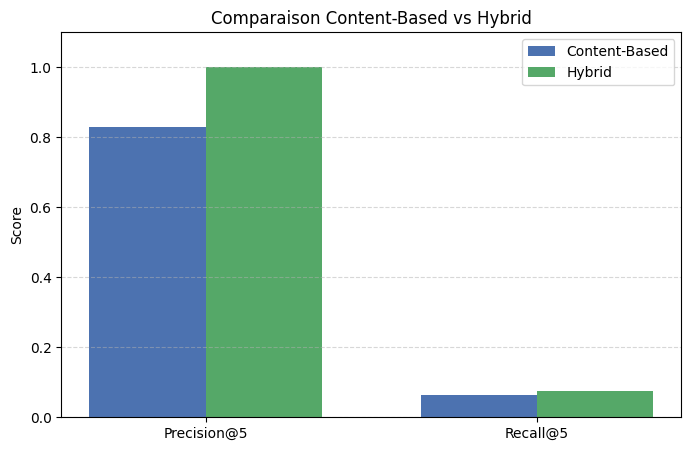

In [37]:
import matplotlib.pyplot as plt
import numpy as np

precision_cb = 0.828
recall_cb = 0.063

precision_hb = 1.000
recall_hb = 0.076

metrics = ["Precision@5", "Recall@5"]
content_values = [precision_cb, recall_cb]
hybrid_values = [precision_hb, recall_hb]

x = np.arange(len(metrics))  # positions
width = 0.35  # largeur des barres

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, content_values, width, label="Content-Based", color="#4C72B0")
plt.bar(x + width/2, hybrid_values, width, label="Hybrid", color="#55A868")

plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Comparaison Content-Based vs Hybrid")
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


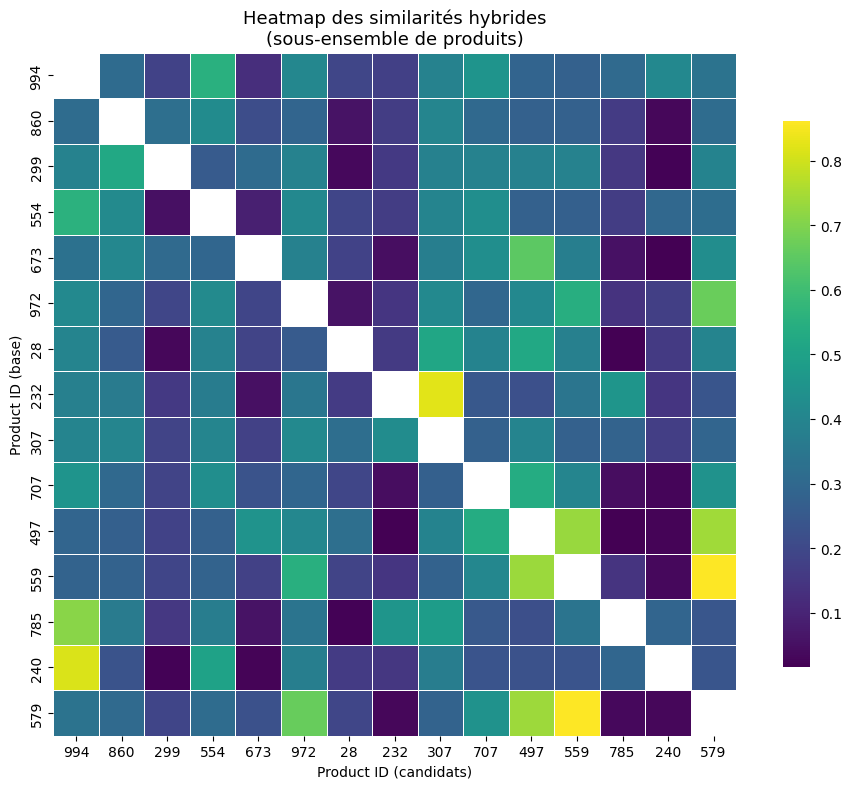

In [40]:
import seaborn as sns

def build_hybrid_score_matrix(
    base_ids,
    usage=None,
    budget_level=None,
    min_rating_constraint=3.5,
    min_rating_kb=3.5,
    w_content=0.6,
    w_constraint=0.2,
    w_knowledge=0.2
):
    """
    Construit une matrice (DataFrame) où chaque ligne = produit de base,
    chaque colonne = produit candidat, valeur = hybrid_score.
    """
    base_ids = list(base_ids)
    matrix = pd.DataFrame(index=base_ids, columns=base_ids, dtype=float)
    
    for pid in base_ids:
        recs = hybrid_recommend(
            base_product_id=pid,
            max_price=None,
            min_rating_constraint=min_rating_constraint,
            usage=usage,
            budget_level=budget_level,
            min_rating_kb=min_rating_kb,
            w_content=w_content,
            w_constraint=w_constraint,
            w_knowledge=w_knowledge,
            top_k=len(products)  # pour avoir tous les scores
        )
        s = recs.set_index("Product ID")["hybrid_score"]
        common_ids = [p for p in base_ids if p in s.index]
        matrix.loc[pid, common_ids] = s.loc[common_ids]
    
    return matrix

# Sélection d'un petit sous-ensemble de produits (par ex. 15)
subset_ids = products["Product ID"].sample(15, random_state=0)

hybrid_matrix = build_hybrid_score_matrix(
    base_ids=subset_ids,
    usage=None,            # ou "sport", "work", etc.
    budget_level=None,
    min_rating_constraint=3.5,
    min_rating_kb=3.5,
    w_content=0.6,
    w_constraint=0.2,
    w_knowledge=0.2
)

plt.figure(figsize=(10, 8))
sns.heatmap(
    hybrid_matrix,
    cmap="viridis",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Heatmap des similarités hybrides\n(sous-ensemble de produits)", fontsize=13)
plt.xlabel("Product ID (candidats)")
plt.ylabel("Product ID (base)")
plt.tight_layout()
plt.show()
